## 1. Locate a Station Near The Event

### Global Variable Constants 

In [1]:
with open('event_name.txt', 'r') as file:
    event_name = file.read()

In [81]:
# CHANGE THIS VARIABLE TO CHANGE EVERYTHING IN THE FILE
# event_name = 'Alaska'

In [106]:
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from types import MappingProxyType

class Names:
    Amatrice = 'Amatrice'
    Oklahoma = 'Oklahoma'
    SouthAmerica = 'SouthAmerica'
    California = 'California'
    Alaska = 'Alaska'
    Costa = 'Costa'
    Puerto = 'Puerto'

def Day(num):
    return 60*60*24*num

def get_event_info(name):
    """
    Provids a dictionary (MappingProxyType) of information to populate the global variables needed in the file.
    The chosen event is in a seismologically active area. A station is chosen near the event to get data.
    @param name: Can be one of - "Amatrice", "Patitirion"
    @return: ProxyMapType, containing the information about the event.
    """
    info: MappingProxyType = None
    if name == Names.Amatrice:
        info = dict(
            Latitude='42.790',
            Longitude='13.150',
            Time="2016-08-24 03:36:32",
            StartTime="2012-08-24",
            EndTime="2018-08-24",
            Client="INGV",
            Name="Amatrice",
            PrePadding=4,
            PostPadding=16,
            StationRadius=.2,
            LocalEventRadius=.2
        )

    elif name == Names.Oklahoma:
        info = dict(
            Latitude='37.081',
            Longitude='-97.309',
            Time="2018-5-15 20:14:49",
            StartTime="2015-10-15",
            EndTime="2017-10-15",
            Client="IRIS",
            Name="Oklahoma",
            PrePadding=6,
            PostPadding=14,
            Network="GS",
            Station='KAN01',
            StationRadius=1,
            LocalEventRadius=1
        )
    
    elif name == Names.SouthAmerica:
        info = dict(
            Latitude='-25.3',
            Longitude='-71',
            Time="2018-02-20 23:18:32",
            StartTime="2013-10-15",
            EndTime="2018-01-15",
            Client="IRIS",
            Name="SouthAmerica",
            PrePadding=6,
            PostPadding=14,
            AddTime=10,
            Network='C',
            Station='GO02',
            StationRadius=3,
            LocalEventRadius=1
        )
    
    elif name == Names.California:
        info = dict(
            Latitude='33.557',
            Longitude='-115.888',
            Time="2018-02-20 23:18:32",
            StartTime="2016-10-15",
            EndTime="2018-01-15",
            Client="IRIS",
            Name="California",
            PrePadding=8,
            PostPadding=12,
            StationRadius=1,
            LocalEventRadius=1
        )
    
    elif name == Names.Alaska:
        info = dict(
            Latitude='61',
            Longitude='-150',
            Time="2018-02-20 23:18:32",
            StartTime="2015-01-01",
            EndTime="2017-02-26",
            Client="IRIS",
            Network="AK",
            Station="FIRE",
            Name="Alaska",
            PrePadding=5,
            PostPadding=15,
            StationRadius=2,
            LocalEventRadius=1.5
        )
        
    elif name == Names.Costa:
        info = dict(
            Latitude='19.433',
            Longitude='-155',
            Time="2005-02-20",
            StartTime="2014-05-05",
            EndTime="2018-02-26",
            Client="IRIS",
            Network="NU",
            Station="BC8A",
            Name="Costa",
            PrePadding=2,
            PostPadding=18,
            StationRadius=1,
            LocalEventRadius=1
        )
        
    elif name == Names.Puerto:
        info = dict(
            Latitude='18',
            Longitude='-67',
            Time="2005-02-20",
            StartTime="2014-05-05",
            EndTime="2018-02-26",
            Client="IRIS",
            Network="PR",
            Station="AGPR",
            Name="Puerto",
            PrePadding=7,
            PostPadding=13,
            StationRadius=3,
            LocalEventRadius=1
        )
    
    if info: 
        return MappingProxyType(info)
    raise ValueError(f"Name '{name}' not found")

In [107]:
# Retrieving the quake information            
event = get_event_info(event_name)   # dict containing the information to populate the variables

# Constants
LATITUDE = event['Latitude']                # Latitude of Event
LONGITUDE = event['Longitude']              # Longitude of Event
STARTTIME = UTCDateTime(event['StartTime']) # Starttime of Data Collection
ENDTIME = UTCDateTime(event['EndTime'])     # Endtime of Data Collection
CLIENT_NAME = event['Client']               # Client to retrieve event from
NAME = event['Name'] + 'Quakes'             # Folder name to write spectrograms to

STATION_MAX_RADIUS = event['StationRadius'] # Pick as station within this distance of the event
MAX_RADIUS = event['LocalEventRadius']      # How far local events can be from the station
NONLOCAL_MIN_RADIUS = 6                     # Min Radius for Nonlocal Events
NUM_EVENTS = 30                            # How many events to retrieve and write                     # Event time window duration
NONLOCAL_NUM_EVENTS = 10
NUM_NOISE_EVENTS = 10

DURATION = 20                              # Time in seconds, centered around the event          
PADDING = 20                               # Get waveforms padding length, and then trim to the duration after filtering
ADD_TIME = event.get('AddTime', 0)         # Time to add to all events to correct for arrival times

PRE_PADDING = event['PrePadding']
POST_PADDING = event['PostPadding']

# Time period to collect noise events
NOISE_START = STARTTIME
NOISE_END = NOISE_START + Day(60)

# If specific network and station are specified
NETWORK = event.get('Network')
STATION = event.get('Station')

# Filtering Constants for the Spectrograms
MIN_FREQ = 1
MAX_FREQ = 30
    
# Code
client = Client(CLIENT_NAME)

### Get Valid Station Near the Location 

In [108]:
# Verify that waveform FDSN works, so you don't waste time getting to the bottom 

from obspy.core.inventory import Inventory, Station, Network

def get_all_stations(max_radius) -> Inventory:
    """ Use this to find a valid station with the correct components """
    return client.get_stations(latitude=LATITUDE,
                               longitude=LONGITUDE,
                               maxradius=max_radius)

def get_channel_names(stream):
    """ Returns a list of names of each component, in the order they appear in the stream """
    return [trace.stats.channel for trace in stream]

def verify_fsdn(network, station):
    """ 
    Makes a call to the server. Requires 'HN*' component, and the ability to 'get_waveforms' from the station 
    Sometimes the stations are missing data, so it's important to actually make a request and get the waveform data.
    """
    client = Client(CLIENT_NAME)
    time = station.start_date + Day(365)
    waves = client.get_waveforms(network.code, station.code, "*", "HN*", time, time + DURATION)
    #print(get_channel_names(waves))
    return True

def get_valid_stations(inventory):
    """ Attempts to get waveforms from a station, with the veriy_fsdn function. Returns valid stations. """
    valid = []
    for network in inventory:
        for station in network:
            try:
                verify_fsdn(network, station)
            except Exception:
                print("Failed station:", station.code)
            else:
                print("Succeeded station:", station.code, network.code)
                valid.append(station)
    return valid


#### *Optional: Find a station with the correct components

In [109]:
# inv = get_all_stations(STATION_MAX_RADIUS)
# get_valid_stations(inv)

In [110]:
# Types
inventory: Inventory
network: Network
station: Station
    
inventory = client.get_stations(startbefore=STARTTIME, 
                               endafter=ENDTIME,
                               latitude=LATITUDE,
                               longitude=LONGITUDE,
                               maxradius=STATION_MAX_RADIUS
                              )
# By default, get the first station and network unless specified
network = (inventory.select(NETWORK) if NETWORK else inventory)[0]
station = (network.select(STATION) if STATION else network)[0]

In [111]:
# Verifies that the selected station supports 'get_waveforms' - saves time to not run the rest of the code
assert verify_fsdn(network, station)

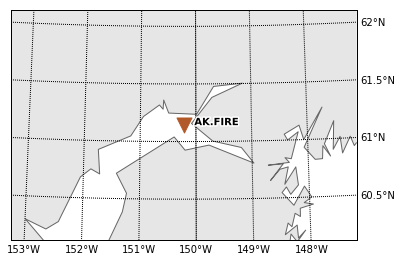

In [112]:
# Optional, Visualize the Station
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    network.select(STATION).plot(projection='local')

## 2. Retrieve Local and Non-Local Events From The Station 

### Functions for getting the noise times

#### Get Events

In [113]:
from obspy.clients.fdsn import Client
from obspy.core.event import Catalog

# Types
local_catalog_events: Catalog
nonlocal_catalog_events: Catalog
    

# Code
client = Client(CLIENT_NAME)

# Local Events
local_catalog = client.get_events(latitude=station.latitude, 
                                 longitude=station.longitude,
                                 maxradius=MAX_RADIUS,  # Local
                                 starttime=STARTTIME,
                                 limit=NUM_EVENTS,
                                 endtime=ENDTIME
                                 )

# Nonlocal Events
nonlocal_catalog = client.get_events(latitude=station.latitude, 
                                 longitude=station.longitude,
                                 #minradius=NONLOCAL_MIN_RADIUS,  # Nonlocal
                                 limit=NONLOCAL_NUM_EVENTS,
                                 starttime=STARTTIME,
                                 #endtime=ENDTIME
                                 )


# Noise Exclude Events
noise_catalog = client.get_events(latitude=station.latitude, 
                                 longitude=station.longitude,
                                 starttime=NOISE_START,
                                 endtime=NOISE_END,
                                 maxradius=10
                                 )


print("LOCAL EVENTS:", len(local_catalog))
print("NONLOCAL EVENTS:", len(nonlocal_catalog))
print("NOISE EVENTS to Exclude:", len(noise_catalog))

LOCAL EVENTS: 30
NONLOCAL EVENTS: 10
NOISE EVENTS to Exclude: 432


### Visualize Events Local and NonLocal

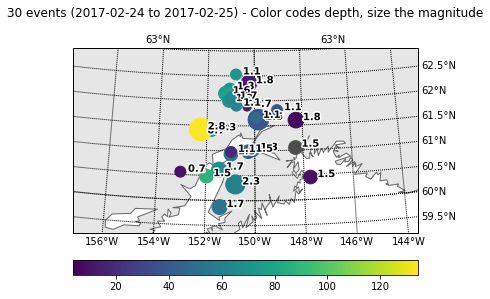

In [114]:
# Plot Events
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    local_catalog.plot(projection="local")
#     noise_catalog.plot()

## 3. Retrieve Waveforms 

### Get times where events occur

In [115]:
import random
import math
from bisect import bisect
from collections import namedtuple
from typing import List
from obspy.core.event import Catalog


# Holds a UTCDateTime start and end times of an event
Time = namedtuple('Time', ('start', 'end'))   

def find_closest_index(a, x):
    """
    Find index of rightmost value less than x via binary search
    @param a: Indexable object, the list to look through - MUST BE SORTED
    @param x: Any, the item to find the closest index for in a
    """
    i = bisect(a, x) 
    if i:
        return i
    return 0

def overlaps(time: Time, time2: Time):
    """
    Determines whether two times overlap.
    @returns: boolean, True if the time1 overlaps with time2  
    """
    # Starts after the second time ends, or ends before the second time starts
    return not ((time.start > time2.end) or (time.end < time2.start))

def encompassed(time: Time, sorted_times: List[Time]):
    """
    Determines whether time overlaps with any times in sorted_times
    @param time: Time
    @param sorted_times: sorted list of Time - the list MUST be sorted for this to work
    @return: boolean, True if the time overlaps
    """
    index = find_closest_index(sorted_times, time)
    try:
        left = overlaps(time, sorted_times[index-1])
        curr = overlaps(time, sorted_times[index])
        right = overlaps(time, sorted_times[index+1])
        return any((left, curr, right))
    except IndexError:
        return True     

def get_noise_times(times_to_exclude: List[UTCDateTime], 
                    startafter: UTCDateTime, endbefore: UTCDateTime, amount: int, duration: float):
    """
    Generates a list of noise times, which are not in the times_to_exclude
    @param times_to_exclude: a list of times of events 
    @param startafter: Generate noise windows after this time
    @param endbefore: Generate noise windows before this time
    @param amount: How many noise windows to generate
    @param duration: How long each event in times_to_exclude and noise window should be, to prevent overlapping
    """
    exclude = [Time(time-duration/2, time + duration/2) for time in times_to_exclude]
    exclude.sort()
    noise_times = []
    
    def random_time():
        return startafter + random.randint(0, math.floor(endbefore - startafter))
    
    # Generate a random time
    while len(noise_times) < amount:
        rt = random_time()
        rand_time = Time(rt - duration/2, rt + duration/2)
                         
        if not encompassed(rand_time, exclude):
            noise_times.append(rt)
            index = bisect(exclude, rand_time)
            exclude = exclude[:index] + [rand_time] + exclude[index:]
        
    return noise_times




In [116]:
from obspy.core import Stream
from obspy.core.event.event import Event
from pprint import pprint
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import kilometers2degrees
from multiprocessing import Pool
from functools import partial
from obspy.taup.helper_classes import SlownessModelError


# Constants
model = TauPyModel(model="prem")

# Functions
def get_event_time(station, event) -> UTCDateTime:
    """ Corrects an event time when it arrived at a station, correcting for the PREM distance. """
    event_time = event.origins[0].time
    try:
        p_arrival, s_arrival = compute_distance(station, event)
    except (SlownessModelError, IndexError):
        return None
    else:
        event_time += p_arrival
        return event_time


def get_event_times(catalog: Catalog, station: Station) -> List[UTCDateTime]:
    """
    Gets event times from a catalog and returns a list of them, corrected with the above functino.
    """
    times = [get_event_time(station, event) for event in catalog]
    times = filter(lambda time: time is not None, times)                     # Remove errored times
    return list(times)


def compute_distance(station: Station, event: Event):
    """ Computes the time offset of an event to reach a station, based on PREM """
    origin = event.origins[0]
    
    event_distance = gps2dist_azimuth(station.latitude, station.longitude,
                                      origin.latitude, origin.longitude)[0]
    
    depth = origin.depth/1000
    distance = kilometers2degrees(event_distance / 1000)   # Meter to kilometer to degrees
    arrivals = model.get_travel_times(source_depth_in_km=depth,  # meter to kilometer
                                      distance_in_degree=distance,
                                      phase_list=["p", "s", "P", "S"]
                                     )

    p, s = arrivals[0].time, arrivals[1].time   # Time in seconds
    return p, s


    
def parallel_get_event_times(catalog: Catalog, station):
    """
    Parallelizes the 'get_event_time' function to make computation faster.
    """
    work = catalog   # Args that will be passed to the function

    # Run with multiprocess
    pool = Pool()
    times = pool.map(partial(get_event_time, station), work)             # Map the args
    times = filter(lambda time: time is not None, times)                     # Remove errored times
    return list(times)    


In [117]:
# Types
local_times: List[UTCDateTime]
nonlocal_times: List[UTCDateTime]
noise_times: List[UTCDateTime]
    
    
# Code
local_times = get_event_times(local_catalog, station)
nonlocal_times = get_event_times(nonlocal_catalog, station)
_noise_times = get_event_times(noise_catalog, station)

noise_times = get_noise_times(_noise_times, 
                              NOISE_START, # startafter
                              NOISE_END, # endbefore
                              NUM_NOISE_EVENTS, 
                              DURATION)

print("Got times")

Got times


### Prepare data for the client

In [118]:
# Functions
end = lambda time: time + PADDING + ADD_TIME
start = lambda time: time - PADDING + ADD_TIME

def create_bulk(times):
    return [(network.code, station.code, "*", "HN*", start(time), end(time)) for time in times]


# Code
local_bulk = create_bulk(local_times)
nonlocal_bulk = create_bulk(nonlocal_times)
noise_bulk = create_bulk(noise_times)
print("Created Bulks")

Created Bulks


### Get Waveforms 

In [119]:
import asyncio  
import time
from functools import wraps
from obspy.clients.fdsn.header import FDSNNoDataException, FDSNException


def slide(iterable, num, stagger=None):
    """ 
    A sliding window over an iterator, yielding sub arrays.
    @param iterable: Iterable
    @param num: int, the size of each subarray
    @param stagger: int, the number of elements to start the next subarray by 
    
    Example:
    for arr in slide(list(range(98)), 5):
        print(arr)
    """
    stagger = num - stagger if stagger else 0
    start = 0
    end = num
    
    while start + stagger < len(iterable):
        yield iterable[start:end]
        start = end - stagger
        end += num - stagger
        
        

class AsyncClient(Client):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loop = asyncio.get_event_loop()
    
    async def async_get_waveforms(self, *args, **kwargs):
        """ 
        Get waveforms asyncronously 
        @param *args, **kwargs: the arguments passed to Client.get_waveforms
        @return: future
        """
        
        # kwargs can't be passed to loop.run_in_executor, so create a wrapper function.
        @wraps(self.get_waveforms)
        def call_with_kwargs(*args):
            return self.get_waveforms(*args, **kwargs)
            
        future = self.loop.run_in_executor(None, call_with_kwargs, *args)
        return await future
    
    def _get_batch(self, batch: List, bulk_kwargs: dict):
        """
        Retrieves a batch of waveforms by calling 'get_waveforms' for each list of args in the batch
        @param batch: list[list],each sublist is arguments to be passed to get_waveforms
        @param bulk_kwargs: keyword arguments to pass the get_waveforms function. Will be applied to every batch.
        """
        tasks = [self.async_get_waveforms(*data, **bulk_kwargs) for data in batch] # List of Asyncio Tasks
        results = self.loop.run_until_complete(asyncio.gather(*tasks))             # Blocks until finished 
        return results
    
    def get_waveforms_bulk(self, bulk: List[List], batch_size=10, separation=1, bulk_kwargs=None, skip_errors=True):
        """
        Gets waveforms in a bulk asynchronously.
        @param bulk: List[List], data to pass get_waveforms like at - https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms_bulk.html
        @param batch_size: how many simultaneous requests are sent at one. Keep this number < 10 
        @param bulk_kwargs: dict, kwargs to pass to each get_waveforms request because you can't store them in the bulk list.
        @param skip_errors: boolean, if False raises FSDN error if the server is missing a waveform  
        @return: List[Stream], a list of the waveforms
        """
        if batch_size > 10: raise ValueError("Batch size too high, could overload server.")
            
        waveforms = []
        bulk_kwargs = bulk_kwargs or {}
        
        generate_waveforms = self.yield_waveforms_bulk(bulk, batch_size, separation, bulk_kwargs, skip_errors)
        
        for i, result in enumerate(generate_waveforms):
            waveforms.extend(result)
            print(f"Got batch {i+1}: {len(waveforms)}/{len(bulk)}", end="\r")
        
        print("\nDone.")
        return waveforms
    
    def yield_waveforms_bulk(self, bulk, batch_size=10, separation=1, bulk_kwargs=None, skip_errors=True):
        """
        Yields a list of streams of size batch_size. Each call to the generator makes another call to the server.
        This way you can be more strategic about how you get your data, hold it in memory, etc.
        @yield: List[Stream]
        """
        bulk_kwargs = bulk_kwargs or {}

        if batch_size > 10: 
            raise ValueError("Batch size too high, could overload server.")

        for i, batch in enumerate(slide(bulk, batch_size)): 
            try:
                yield self._get_batch(batch, bulk_kwargs)
            except FDSNNoDataException as e:
                if skip_errors:
                    print(f"Skipping batch {i} FDSNNoDataException")
                    continue
                raise e
            except FDSNException as e:
                if skip_errors:    
                    print("FDSN Exception: ", e)
                    continue
                raise e
            finally:
                time.sleep(separation)   # Prevent overloading the server

#### Download waveforms Asynchronously

In [120]:
client = AsyncClient(CLIENT_NAME)

In [121]:
# Get Waveforms

local_waveforms = client.get_waveforms_bulk(local_bulk, 
                                            batch_size=5, 
                                            bulk_kwargs=dict(attach_response=True),
                                            skip_errors=True)

print("\nRetrieved Local:", len(local_waveforms))

Got batch 6: 30/30
Done.

Retrieved Local: 30


In [122]:
nonlocal_waveforms = client.get_waveforms_bulk(nonlocal_bulk, 
                                               batch_size=5, 
                                               bulk_kwargs=dict(attach_response=True),
                                               skip_errors=True)

print("\nRetrieved Nonlocal:", len(nonlocal_waveforms))

Got batch 2: 10/10
Done.

Retrieved Nonlocal: 10


In [123]:
noise_waveforms = client.get_waveforms_bulk(noise_bulk, 
                                               batch_size=5, 
                                               bulk_kwargs=dict(attach_response=True),
                                               skip_errors=True)

print("\nRetrieved Noise:", len(noise_waveforms))

Got batch 2: 10/10
Done.

Retrieved Noise: 10


#### Write Waveforms

In [124]:
from typing import List
from obspy import Stream
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import glob
import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
        
def write_waveforms(waveforms: List[Stream], path):
    create_directory(path)
    for i, stream in enumerate(waveforms):
        stream.write(os.path.join(path, f'{i}.mseed'), format="MSEED")
        
        
def write_waveform(stream, file_path):
    print("Writing: ", os.path.basename(file_path), end='\r')
    stream.write(file_path, format="MSEED")
    

def parallel_write_waveforms(waveforms: List[Stream], path):
    print("Writing Waveforms...")
    create_directory(path)

    work = [] 
    
    # Prep the file paths
    for i, stream in enumerate(waveforms):
        file_path = os.path.join(path, f'{i}.mseed')
        
        # Add the args for each stream
        work.append(
            (stream, file_path)  
        )

    # Run with multiprocess
    pool = Pool()
    pool.starmap(write_waveform, work)
    
    print("\nWrote Waveforms")

def remove_response(waveforms: List[Stream]):
    for stream in waveforms:
        stream.remove_response(output='DISP', water_level=140)


In [125]:
import warnings, os
# Constants
DIR_PATH = os.path.join(os.getcwd(), f"waveforms/{NAME}")

# Write Waveforms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    parallel_write_waveforms(local_waveforms, os.path.join(DIR_PATH, "local"))   
    parallel_write_waveforms(nonlocal_waveforms, os.path.join(DIR_PATH, "non_local"))   
    parallel_write_waveforms(noise_waveforms, os.path.join(DIR_PATH, "noise"))   
    
print("Finished Writing")

Writing Waveforms...

Wrote Waveforms
Writing Waveforms...

Wrote Waveforms
Writing Waveforms...

Wrote Waveforms
Finished Writing


### *Optional, read waveforms

In [126]:
### READ WAVEFORMS ####

from obspy import read
import glob
import os


# NAME = 'OklahomaQuakes'


# noise_path = os.path.join(os.getcwd(), f"waveforms/{NAME}/noise")
# local_path = os.path.join(os.getcwd(), f"waveforms/{NAME}/local")
# nonlocal_path = os.path.join(os.getcwd(), f"waveforms/{NAME}/non_local")

# def read_waveforms(dir_path):
#     files = glob.glob(os.path.join(dir_path, '*.mseed'))
#     waveforms = [read(file) for file in files]
#     return waveforms

# local_waveforms = read_waveforms(local_path)
# nonlocal_waveforms = read_waveforms(nonlocal_path)
# noise_waveforms = read_waveforms(noise_path)

## 4. Filter 

In [144]:
from obspy import Stream
import copy

def filter_waveforms(waveforms: List[Stream]) -> List[Stream]:
    """ 
    Filters the waveforms (in place) 
    @return: generator -> Stream
    """
    assert PRE_PADDING + POST_PADDING == DURATION
    for stream in waveforms:
        event_start = stream[0].stats.starttime + PADDING
        window_start = event_start - 5
        window_end = event_start + 15
        stream.filter('bandpass', freqmin=MIN_FREQ, freqmax=MAX_FREQ)
        stream.trim(window_start, window_end)
                                                            
    return waveforms

    
local_waves = filter_waveforms(copy.deepcopy(local_waveforms))
nonlocal_waves = filter_waveforms(copy.deepcopy(nonlocal_waveforms))
noise_waves = filter_waveforms(copy.deepcopy(noise_waveforms))
print("Filtered")


Filtered


## 5. Write Spectrograms

In [15]:
from typing import List
from obspy import Stream
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import glob
import os
    

def remove_borders(path):
    """ 
    Removes borders of all .png files in curr directory  
    Must have ImageMagik installed.
    """
    png_paths = glob.glob(f"{path}/*.png")
    
    for file in png_paths:
        print("Trimming: ", file, end='\r')
        !convert $file -trim +repage $file;
    
    
    
def show_spectrogram(stream):
    figure_list = stream.spectrogram(show=False, title="")
    
    for figure, channel in zip(figure_list, get_channel_names(stream)):
        if channel in ('HNE', 'HNN', 'HNZ'):
            axes = figure.gca() 
            axes.set_xlim([0, DURATION])
            axes.set_ylim([0, MAX_FREQ])

            # Get Rid of Whitespace
            axes.axis("off")
            axes.xaxis.set_major_locator(NullLocator())
            axes.yaxis.set_major_locator(NullLocator())

    plt.show()



def write_spectrogram(stream, path):
    """
    @param stream: Stream, the file to make a spectrogram from.
                   Each trace should be one component.
    
    @param path: Str, the directory to write into.
    
    Each component of the stream is written as its own figure, a .png file.
    Components eg. "NNE" are saved as the filename eg. "NNE.png".
    """
    create_directory(path)
    figure_list = stream.spectrogram(show=False, title="")
    
    for figure, channel in zip(figure_list, get_channel_names(stream)):
        if channel in ('HNE', 'HNN', 'HNZ'):
            axes = figure.gca() 
            axes.set_xlim([0, DURATION])
            axes.set_ylim([0, MAX_FREQ])

            # Get Rid of Whitespace
            axes.axis("off")
            axes.xaxis.set_major_locator(NullLocator())
            axes.yaxis.set_major_locator(NullLocator())
            figure.savefig(f"{path}/{channel}.png", bbox_inches='tight', pad_inches=0, transparent=True)

            # Free memory
            figure.clf()
            plt.close("ALL") 

    remove_borders(path)  # Remove borders of all the spectrograms
    
    

def write_spectrograms(waveforms, path):   
    for i, stream in enumerate(waveforms):
        dir_path = os.path.join(path, str(i))
        create_directory(dir_path)
        write_spectrogram(stream, dir_path)
    

def async_write_spectrograms(waveforms, path):
    """
    @param waveforms: List[Stream], the waveforms to make spectrograms from.
    @param path: str, The directory to write to
    
    1. Calls 'write_spectrogram' on each Stream. 
    2. Each stream is written to its own folder
    3. All components are written to their own file as a spectrogram .png image.
    """
    print("Writing Files...")

    work = []   # Args that will be passed to the write_spectrogram function
    
    # Prep the file paths
    for i, stream in enumerate(waveforms):
        dir_path = os.path.join(path, str(i))
        create_directory(dir_path)
        
        # Add the args for each stream
        work.append(
            (stream, os.path.join(path, str(i)))  # arguments to the 'write_spectrogram' function
        )

    # Run with multiprocess
    pool = Pool()
    pool.starmap(write_spectrogram, work)             # Map the 'write_spectrogram' function to the work
    
    print("\nWrote Files")


In [ ]:
import warnings
# Constants
DIR_PATH = os.path.join(os.getcwd(), f"spectrograms/{NAME}")

# Write Waveforms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    async_write_spectrograms(local_waves, os.path.join(DIR_PATH, "local"))   
    async_write_spectrograms(noise_waves, os.path.join(DIR_PATH, "noise"))  
    async_write_spectrograms(nonlocal_waves, os.path.join(DIR_PATH, "non_local"))   



Writing Files...


# Tests

In [28]:
import unittest 

class TestMethods(unittest.TestCase):
 

    def test_overlaps(self):
        time1 = UTCDateTime(2015, 1, 1, 10, 0, 10)
        time2 = UTCDateTime(2015, 1, 1, 10, 0, 19)
        time3 = UTCDateTime(2015, 1, 1, 10, 0, 30)
        t1 = Time(time1, time1 + 10)
        t2 = Time(time2, time2 + 10)
        t3 = Time(time3, time3 + 10)
        self.assertTrue(overlaps(t1, t2))
        self.assertFalse(overlaps(t2, t3))

        
    def test_encompassed(self):
        t = UTCDateTime(2015, 1, 1, 10, 0, 0) 
        times = [Time(t + 10*i, t + 10*(i+1)) for i in range(1, 7)]  # 1 minute of times 
        times.append(Time(t+1000, t+1010))
        times.append(Time(t+1010, t+1020))
        times.sort()                           # sorted just to remember that the function requires sorted times
        
        
        # Encompassed within the times
        self.assertTrue(encompassed(Time(t+30, t+40), times))
        
        # Not encompassed
        self.assertFalse(encompassed(Time(t+990, t+999), times))
        
        # Value should be within the range of times... otherwise it is invalid.
        # This is because we only have knowledge of events between the start and end time
        # we can't generate noise times outside this range.
        with self.assertRaises(ValueError):
            encompassed(Time(t-10, t), times) 
            
            
    def test_find_closest_index(self):
        lst = [1, 2, 3, 5, 6]
        self.assertEqual(find_closest_index(lst, 2), 2)  # defaults to finding index to the right  
        self.assertEqual(find_closest_index(lst, 4), 3) 
        
        with self.assertRaises(ValueError):
            find_closest_index(lst, 0)
            
            
            
    def test_get_noise_times(self):
        t = UTCDateTime(2015, 1, 1, 10, 0, 0) 
        exclude = [t + 60*i for i in range(1, 11)]  # 10 times in a 10 minute range 
    
        times = get_noise_times(exclude, startafter=exclude[0], endbefore=exclude[-1], amount=10, duration=10)
        
        
        # Make sure none of the noise times overlap with the event (exclude) times
        exclude_times = [Time(time, time+10) for time in exclude]
        self.assertFalse(any((encompassed(Time(time, time+10), exclude_times)) for time in times))
        
        # Make sure that the times are generated in the correct time window
        times.sort()
        self.assertTrue((times[0] > exclude[0]) and (times[-1] < exclude[-1]))
        
        # Should generate the correct amount
        self.assertEqual(len(times), 10)
        
        
    def test_slide(self):
        gen = slide(list(range(7)), 3)
        self.assertEqual(next(gen), [0, 1, 2])
        self.assertEqual(next(gen), [3, 4, 5])
        self.assertEqual(next(gen), [6])
        
        res = list(slide(list(range(7)), 3, 2))
        self.assertEqual(res, [[0, 1, 2], [2, 3, 4], [4, 5, 6]])
    

In [ ]:
# methods = TestMethods()

# suite = unittest.TestLoader().loadTestsFromModule(methods)
# unittest.TextTestRunner().run(suite)


In [147]:
import gc
gc.collect()

AlaskaQuakes
